In [2]:
#Importar las librerias necesarias para hacer el analisis de datos y la visualización
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Descargamos datos diarios de SPY (ETF del S&P 500)
data = yf.download("SPY", start="2010-01-01", end="2024-12-31", group_by="column")


# Mostramos las primeras filas
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.768440,85.813847,84.391060,85.041910,118944600
2010-01-05,85.995483,86.033326,85.405178,85.715470,111579900
2010-01-06,86.056030,86.267934,85.844126,85.912236,116074400
2010-01-07,86.419304,86.525256,85.654932,85.897108,131091100
2010-01-08,86.706871,86.744713,86.018184,86.192245,126402800


Vamos a calcular los retornos logarítmicos ya que son mas estables, simetricos y mejores para modelos. La formula es:
r_t = log(P_t/P_t-1)

In [4]:
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()
data[['Close', 'Log_Return']].head()

Price,Close,Log_Return
Ticker,SPY,
Date,,
2010-01-05,85.995483,0.002644
2010-01-06,86.056030,0.000704
2010-01-07,86.419304,0.004212
2010-01-08,86.706871,0.003322
2010-01-11,86.827995,0.001396


In [5]:
# Calculamos la volatilidad rolling (desviación estándar móvil)
data[('Volatility_10')] = data[('Log_Return')].rolling(window=10).std()
data[('Volatility_20')] = data[('Log_Return')].rolling(window=20).std()

# Mostramos las últimas filas
data[['Log_Return', 'Volatility_10', 'Volatility_20']].tail()


Price,Log_Return,Volatility_10,Volatility_20
Ticker,,,
Date,,,
2024-12-23,0.005970,0.011581,0.008539
2024-12-24,0.011054,0.012189,0.008860
2024-12-26,0.000067,0.011894,0.008790
2024-12-27,-0.010582,0.012240,0.009094
2024-12-30,-0.011477,0.012648,0.009301


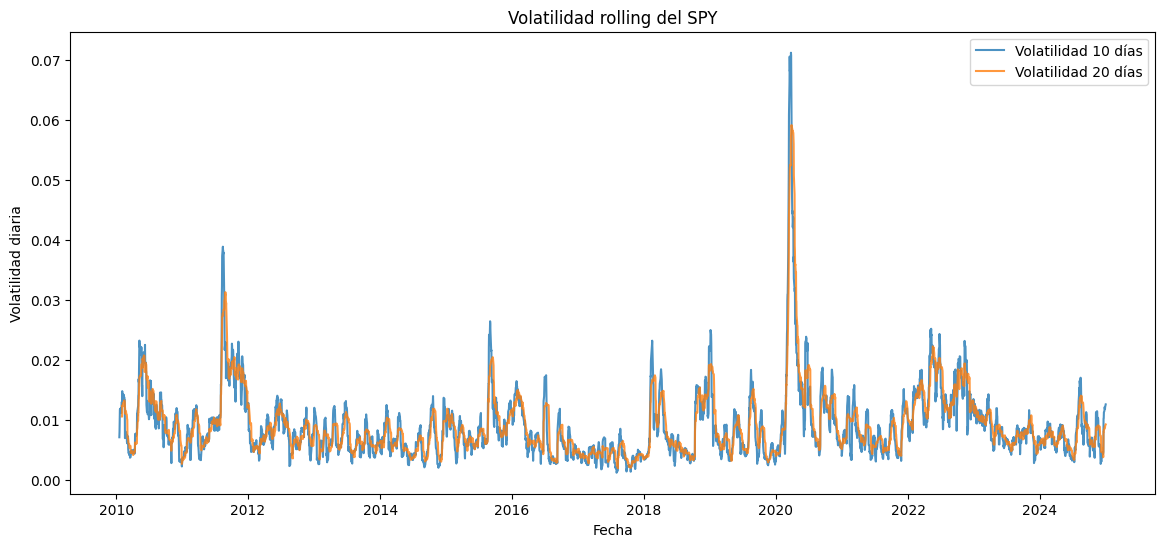

In [6]:
#Visualizacion de la volatilidad en los ultimos 10 y 20 dias
plt.figure(figsize=(14, 6))

plt.plot(data['Volatility_10'], label='Volatilidad 10 días', alpha=0.8)
plt.plot(data['Volatility_20'], label='Volatilidad 20 días', alpha=0.8)

plt.title('Volatilidad rolling del SPY')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad diaria')
plt.legend()
plt.show()


In [7]:
# Creamos variables lag de retornos anteriores
data['Lag_1'] = data['Log_Return'].shift(1)
data['Lag_2'] = data['Log_Return'].shift(2)
data['Lag_5'] = data['Log_Return'].shift(5)

# Eliminamos filas con NaN generadas por los shifts
data = data.dropna()

# Mostramos algunas filas para verificar
data[['Log_Return', 'Lag_1', 'Lag_2', 'Lag_5']].head()

Price,Log_Return,Lag_1,Lag_2,Lag_5
Ticker,,,,
Date,,,,
2010-02-02,0.012031,0.015431,-0.010928,-0.004200
2010-02-03,-0.004995,0.012031,0.015431,0.004746
2010-02-04,-0.031352,-0.004995,0.012031,-0.011539
2010-02-05,0.002065,-0.031352,-0.004995,-0.010928
2010-02-08,-0.007245,0.002065,-0.031352,0.015431


In [8]:
# Función para calcular el VaR histórico (percentil)
def compute_historical_var(series, window, percentile):
    return series.rolling(window=window).quantile(percentile / 100)

# Calculamos el VaR histórico al 5%
data['VaR_5'] = compute_historical_var(data['Log_Return'], window=100, percentile=5)

# Mostramos algunas filas
data[['Log_Return', 'VaR_5']].tail()


Price,Log_Return,VaR_5
Ticker,,
Date,,
2024-12-23,0.005970,-0.017064
2024-12-24,0.011054,-0.013095
2024-12-26,0.000067,-0.009365
2024-12-27,-0.010582,-0.010698
2024-12-30,-0.011477,-0.011548


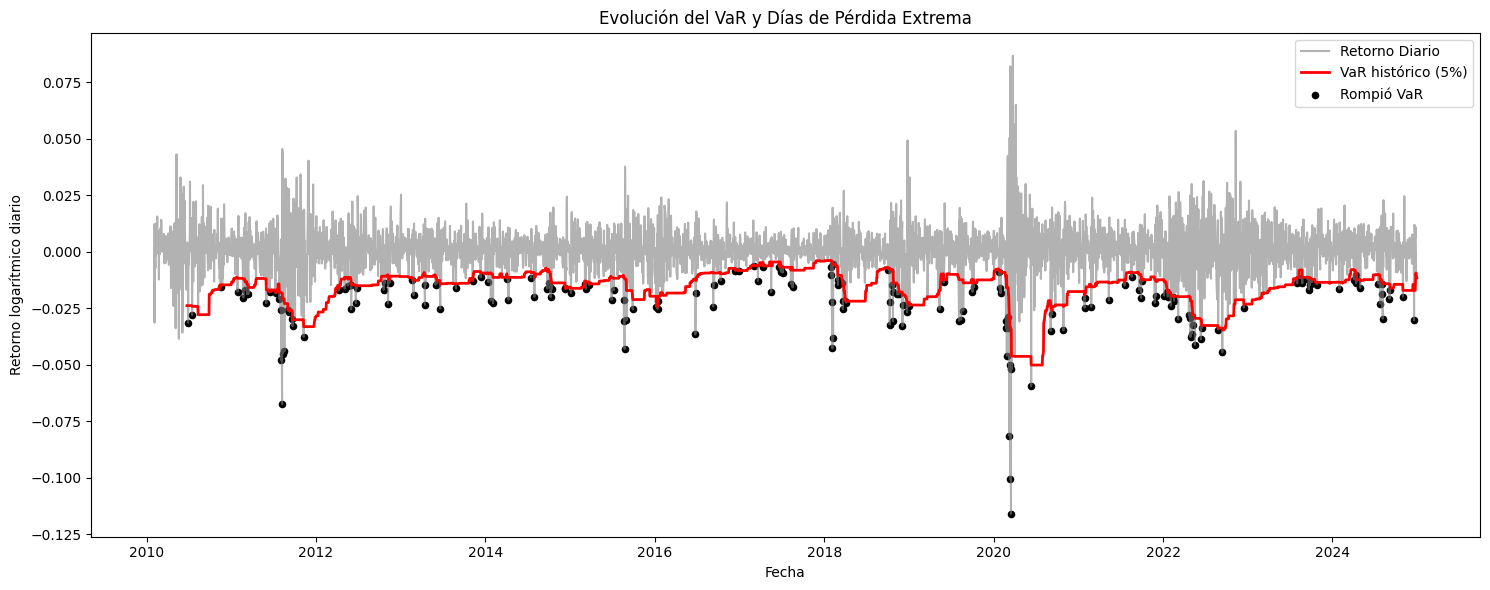

In [9]:
plt.figure(figsize=(15, 6))

# Línea de retornos diarios
plt.plot(data.index, data['Log_Return'], label='Retorno Diario', color='gray', alpha=0.6)

# Línea de VaR histórico (nivel de pérdida esperada al 5%)
plt.plot(data.index, data['VaR_5'], label='VaR histórico (5%)', color='red', linewidth=2)

# Resaltar días donde se rompe el VaR (cuando la pérdida fue peor de lo esperado)
breach = data['Log_Return'] < data['VaR_5']
plt.scatter(data.index[breach], data['Log_Return'][breach], color='black', label='Rompió VaR', s=20)

# Estética del gráfico
plt.title('Evolución del VaR y Días de Pérdida Extrema')
plt.xlabel('Fecha')
plt.ylabel('Retorno logarítmico diario')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Creamos una condición booleana: True donde el retorno es menor al VaR (es decir, el mercado cayó más de lo esperado)
breaches = data['Log_Return'] < data['VaR_5']

# Contamos cuántos True hay (cuántas veces se rompió el VaR)
num_breaches = breaches.sum()

# También podemos calcular el total de días evaluados
total_days = breaches.count()

# Y calcular la proporción de rompimientos
breach_rate = num_breaches / total_days

# Imprimimos los resultados
print(f"Número de días en los que se rompió el VaR (al 5%): {num_breaches}")
print(f"Número total de días considerados: {total_days}")
print(f"Proporción de rompimientos: {breach_rate:.2%}")


Número de días en los que se rompió el VaR (al 5%): 189
Número total de días considerados: 3753
Proporción de rompimientos: 5.04%


Como calculamos un VaR al 5%, podemos ver que aproximadamente el 5% de los días los retornos lo rompen

In [11]:
# Creamos la variable objetivo: 1 si se rompió el VaR, 0 si no
data['Target'] = (data['Log_Return'] < data['VaR_5']).astype(int)

# Verificamos cuántos días fueron clase 1 y cuántos clase 0
print(data['Target'].value_counts())

# Mostramos una muestra de los datos
data[['Log_Return', 'VaR_5', 'Target']].tail()


Target
0    3564
1     189
Name: count, dtype: int64


Price,Log_Return,VaR_5,Target
Ticker,,,
Date,,,
2024-12-23,0.005970,-0.017064,0
2024-12-24,0.011054,-0.013095,0
2024-12-26,0.000067,-0.009365,0
2024-12-27,-0.010582,-0.010698,0
2024-12-30,-0.011477,-0.011548,0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Seleccionar features e input/output
features = ['Lag_1', 'Lag_2', 'Lag_5', 'Volatility_10', 'Volatility_20']
X = data[features]
y = data['Target']

# 2. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 4. Predecir y evaluar
y_pred = model.predict(X_test)

print(" Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))


 Matriz de confusión:
[[713   0]
 [ 38   0]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.949     1.000     0.974       713
           1      0.000     0.000     0.000        38

    accuracy                          0.949       751
   macro avg      0.475     0.500     0.487       751
weighted avg      0.901     0.949     0.925       751



c:\Users\Ferna\OneDrive\Documentos\SmartVaR\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ferna\OneDrive\Documentos\SmartVaR\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ferna\OneDrive\Documentos\SmartVaR\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

El modelo falla completamente en detectar dias peligrosos. Vamos a utilizar XGBoost para entrenar al modelo y vamos a ajustar el peso de la clase minoritaria. Vamos a darle el peso ideal: 3564 / 189 ≈ 18.86 (n clase 0)/(n clase 1)

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Reutilizamos los mismos datos
features = ['Lag_1', 'Lag_2', 'Lag_5', 'Volatility_10', 'Volatility_20']
X = data[features]
y = data['Target']

# 2. Split de entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Entrenamos el modelo XGBoost con peso ajustado
model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=18.86,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train, y_train)

# 4. Evaluamos
y_pred_xgb = model_xgb.predict(X_test)

print("📊 Matriz de confusión (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\n📄 Reporte de clasificación (XGBoost):")
print(classification_report(y_test, y_pred_xgb, digits=3))


📊 Matriz de confusión (XGBoost):
[[568 145]
 [ 17  21]]

📄 Reporte de clasificación (XGBoost):
              precision    recall  f1-score   support

           0      0.971     0.797     0.875       713
           1      0.127     0.553     0.206        38

    accuracy                          0.784       751
   macro avg      0.549     0.675     0.541       751
weighted avg      0.928     0.784     0.841       751



c:\Users\Ferna\OneDrive\Documentos\SmartVaR\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ahora para mejorar el modelo vamos a ampliar el umbral de decisión para clasificar como “día de riesgo” (clase 1) si la probabilidad predicha > 0.4 (en lugar del valor por defecto 0.5)

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. Obtenemos las probabilidades de clase 1
y_proba = model_xgb.predict_proba(X_test)[:, 1]  # columna de clase 1

# 2. Aplicamos un nuevo umbral (por ejemplo, 0.3)
threshold = 0.4
y_pred_custom = (y_proba > threshold).astype(int)

# 3. Evaluamos con el nuevo umbral
print(f"📊 Matriz de confusión (umbral {threshold}):")
print(confusion_matrix(y_test, y_pred_custom))

print(f"\n📄 Reporte de clasificación (umbral {threshold}):")
print(classification_report(y_test, y_pred_custom, digits=3))


📊 Matriz de confusión (umbral 0.4):
[[479 234]
 [ 15  23]]

📄 Reporte de clasificación (umbral 0.4):
              precision    recall  f1-score   support

           0      0.970     0.672     0.794       713
           1      0.089     0.605     0.156        38

    accuracy                          0.668       751
   macro avg      0.530     0.639     0.475       751
weighted avg      0.925     0.668     0.761       751



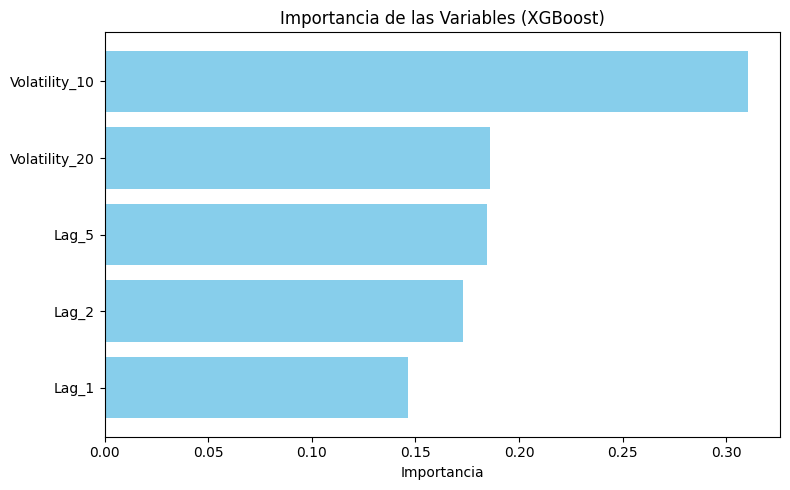

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Creamos un DataFrame con las importancias
importances = model_xgb.feature_importances_
features = ['Lag_1', 'Lag_2', 'Lag_5', 'Volatility_10', 'Volatility_20']

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Gráfico
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Variables (XGBoost)')
plt.gca().invert_yaxis()  # para mostrar la más importante arriba
plt.tight_layout()
plt.show()


Ahora vamos a intentar anadir nuevas variables para intentar mejorar el rendimiento del modelo

In [16]:
#Media Movil (SMA)
data['SMA_10'] = data['Close'].rolling(window=10).mean()

In [ ]:
#RSI: Mide si un activo esta sobre comprado (>70) o sobre vendido (<30)
def compute_rsi(series, window=14):
    delta = series.diff() # ΔP 
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = compute_rsi(data['Close'], window=14)


In [18]:
#Momentum: Sirve para ver la tendencia general del mercado y los cambio respecto al precio a hace n dias.
data['Momentum_5'] = data['Close'] - data['Close'].shift(5)

In [19]:
#limpieza de datos
data = data.dropna()  # eliminamos filas con valores NaN por rolling y shift


In [20]:
features = [
    'Lag_1', 'Lag_2', 'Lag_5',
    'Volatility_10', 'Volatility_20',
    'SMA_10', 'RSI_14', 'Momentum_5'
]

📊 Matriz de confusión (umbral 0.4):
[[599  94]
 [ 14  24]]

📄 Reporte de clasificación (umbral 0.4):
              precision    recall  f1-score   support

           0      0.977     0.864     0.917       693
           1      0.203     0.632     0.308        38

    accuracy                          0.852       731
   macro avg      0.590     0.748     0.612       731
weighted avg      0.937     0.852     0.886       731



c:\Users\Ferna\OneDrive\Documentos\SmartVaR\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:10:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


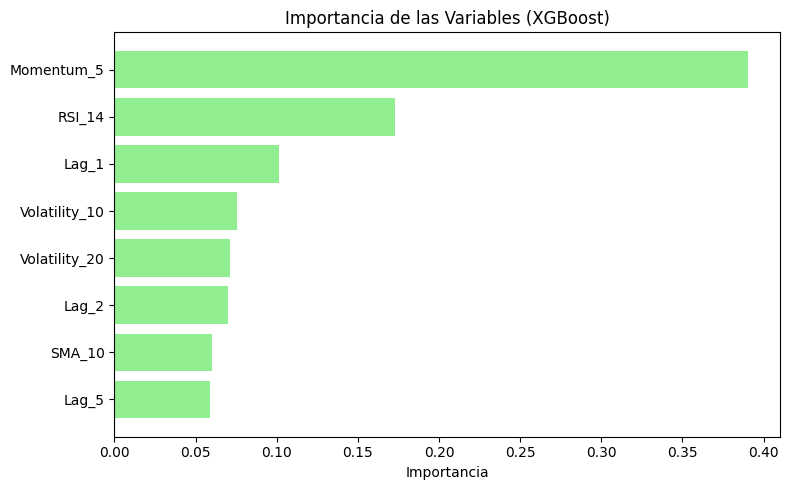

In [21]:
X = data[features]
y = data['Target']

# ================================
# 3. Split de entrenamiento / test
# ================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# 4. Entrenar XGBoost con pesos balanceados
# ================================

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=18.86,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train, y_train)

# ================================
# 5. Ajustar umbral de decisión
# ================================

# Predecimos probabilidades
y_proba = model_xgb.predict_proba(X_test)[:, 1]

# Cambiamos el umbral
threshold = 0.4
y_pred_custom = (y_proba > threshold).astype(int)

# ================================
# 6. Evaluación del modelo
# ================================

print(f"📊 Matriz de confusión (umbral {threshold}):")
print(confusion_matrix(y_test, y_pred_custom))

print(f"\n📄 Reporte de clasificación (umbral {threshold}):")
print(classification_report(y_test, y_pred_custom, digits=3))

# ================================
# 7. Visualización de importancia de variables
# ================================

importances = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.xlabel('Importancia')
plt.title('Importancia de las Variables (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()